<a href="https://colab.research.google.com/github/cristianbalea/ml-project/blob/main/proiect_balea_ciobanica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock, Paper, Scissors image classification

## Downloading the dataset from Kaggle

In [ ]:
! pip install tf-explain
! pip install fastai
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d drgfreeman/rockpaperscissors

! unzip rockpaperscissors.zip

In [ ]:
! pip list

## Importing the libraries

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os 
import fastai
import cv2

import tensorflow as tf
from tf_explain.core.grad_cam import GradCAM
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from keras.optimizers import RMSprop
from keras.preprocessing import image
from fastai.vision.all import *
from pathlib import Path
import PIL
import PIL.Image

## Organizing dataset

In [8]:
build_dir = '/content/rps-cv-images'

rock_dir = os.path.join(build_dir, 'rock')
paper_dir = os.path.join(build_dir, 'paper')
scissors_dir = os.path.join(build_dir, 'scissors')

os.listdir(build_dir)

['scissors', 'paper', 'README_rpc-cv-images.txt', 'rock']

In [9]:
print('paper: ', len(os.listdir(paper_dir)))
print('scissors: ', len(os.listdir(scissors_dir)))
print('rock: ', len(os.listdir(rock_dir)))

paper:  712
scissors:  750
rock:  726


## Explore the dataset

In [10]:
visualisation_dir = Path('../content/rps-cv-images')
print(visualisation_dir)


../content/rps-cv-images


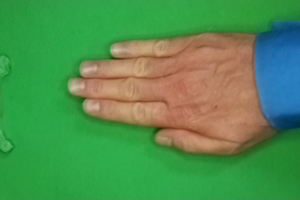

In [11]:
#Images example
papers = list(visualisation_dir.glob('paper/*'))
rocks = list(visualisation_dir.glob('rock/*'))
scissors = list(visualisation_dir.glob('scissors/*'))
Image.open(str(papers[10]))


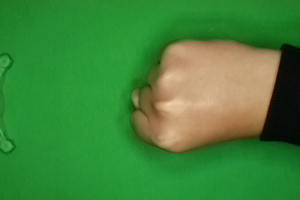

In [12]:
Image.open(str(rocks[1]))

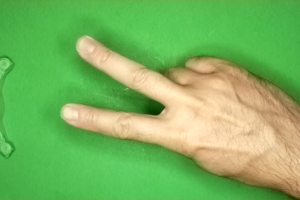

In [13]:
Image.open(str(scissors[45]))

## Data preprocessing

### Data Augmentation

In [14]:
# Create an image data generator with specified transformations and preprocessing
generator = ImageDataGenerator(
    validation_split=0.2,  # Split the data into 80% training and 20% validation
    rescale=1/255,  # Rescale pixel values to range between 0 and 1
    shear_range=0.2,  # Randomly apply shearing transformations
    zoom_range=0.2,  # Randomly apply zooming transformations
    rotation_range=90,  # Randomly rotate the images within the range of -90 to 90 degrees
    fill_mode='nearest'  # Fill in any newly created pixels using the nearest pixel value
)

# Create a directory iterator for training data
train_data = generator.flow_from_directory(
    build_dir,  # Path to the directory containing the training and validation data
    batch_size=32,  # Number of images to load and process at each iteration
    target_size=(150,150),  # Resize input images to the specified dimensions
    subset='training'  # Retrieve images from the training subset of the directory
)

# Create a directory iterator for validation data
val_data = generator.flow_from_directory(
    build_dir,  # Path to the directory containing the training and validation data
    batch_size=32,  # Number of images to load and process at each iteration
    target_size=(150,150),  # Resize input images to the specified dimensions
    subset='validation'  # Retrieve images from the validation subset of the directory
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


### Visualize the augmented data

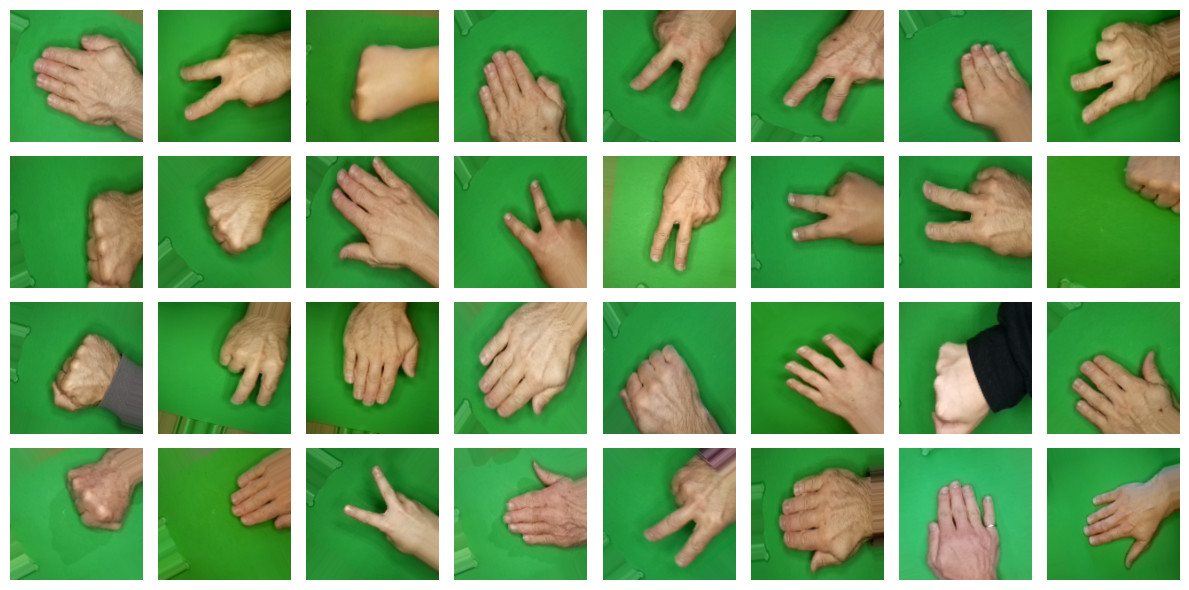

In [15]:
# Retrieve a batch of augmented images from the data generator
augmented_images = next(train_data)

# Display the augmented images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    image = augmented_images[0][i]
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Create a model

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    # Convolutional layer with 32 filters, each of size 3x3.
    # ReLU activation function is applied to introduce non-linearity.
    # The input shape of the layer is (150, 150, 3), representing RGB images.

    tf.keras.layers.MaxPooling2D(2, 2),
    # Max pooling layer with a pool size of 2x2.
    # It reduces the spatial dimensions of the previous layer output by taking the maximum value in each pooling region.

    tf.keras.layers.Dropout(0.2),
    # Dropout layer with a rate of 0.2.
    # It randomly drops 20% of the input units during training to reduce overfitting.

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # Convolutional layer with 64 filters of size 3x3.
    # ReLU activation function is applied to introduce non-linearity.

    tf.keras.layers.MaxPooling2D(2,2),
    # Max pooling layer with a pool size of 2x2.

    tf.keras.layers.Dropout(0.2),
    # Dropout layer with a rate of 0.2.

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # Convolutional layer with 128 filters of size 3x3.
    # ReLU activation function is applied to introduce non-linearity.

    tf.keras.layers.MaxPooling2D(2,2),
    # Max pooling layer with a pool size of 2x2.

    tf.keras.layers.Dropout(0.2),
    # Dropout layer with a rate of 0.2.

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # Convolutional layer with 128 filters of size 3x3.
    # ReLU activation function is applied to introduce non-linearity.

    tf.keras.layers.MaxPooling2D(2,2),
    # Max pooling layer with a pool size of 2x2.

    tf.keras.layers.Flatten(),
    # Flatten layer to convert the 2D feature maps to a 1D feature vector.

    tf.keras.layers.Dense(512, activation='relu'),
    # Fully connected layer with 512 neurons.
    # ReLU activation function is applied.

    tf.keras.layers.Dropout(0.5),
    # Dropout layer with a rate of 0.5.

    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
    # Output layer with 3 neurons, representing the classes of the problem.
    # Softmax activation function is applied to generate class probabilities.
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

## Training the model

In [18]:
class Callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.90):
            print("\nReached %2.2f%% accuracy, training has been stop" %(logs.get('accuracy')*100))
            self.model.stop_training = True
callbacks = Callbacks()


In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [20]:
historyModel = model.fit(
    train_data,
    steps_per_epoch = 25,
    epochs = 20,
    validation_data = val_data,
    validation_steps = 5,
    verbose = 2,
    callbacks = [callbacks])

Epoch 1/20
25/25 - 50s - loss: 1.1580 - accuracy: 0.3462 - val_loss: 1.0971 - val_accuracy: 0.3500 - 50s/epoch - 2s/step
Epoch 2/20
25/25 - 38s - loss: 1.0736 - accuracy: 0.4159 - val_loss: 1.0521 - val_accuracy: 0.4187 - 38s/epoch - 2s/step
Epoch 3/20
25/25 - 36s - loss: 1.0389 - accuracy: 0.4750 - val_loss: 0.9691 - val_accuracy: 0.6375 - 36s/epoch - 1s/step
Epoch 4/20
25/25 - 34s - loss: 0.8785 - accuracy: 0.6473 - val_loss: 0.7803 - val_accuracy: 0.7188 - 34s/epoch - 1s/step
Epoch 5/20
25/25 - 35s - loss: 0.7341 - accuracy: 0.6913 - val_loss: 0.6319 - val_accuracy: 0.7875 - 35s/epoch - 1s/step
Epoch 6/20
25/25 - 33s - loss: 0.5672 - accuracy: 0.7927 - val_loss: 0.4423 - val_accuracy: 0.8188 - 33s/epoch - 1s/step
Epoch 7/20
25/25 - 34s - loss: 0.4897 - accuracy: 0.8003 - val_loss: 0.3836 - val_accuracy: 0.8750 - 34s/epoch - 1s/step
Epoch 8/20
25/25 - 33s - loss: 0.4546 - accuracy: 0.8150 - val_loss: 0.3836 - val_accuracy: 0.8500 - 33s/epoch - 1s/step
Epoch 9/20
25/25 - 33s - loss: 0

## Training results

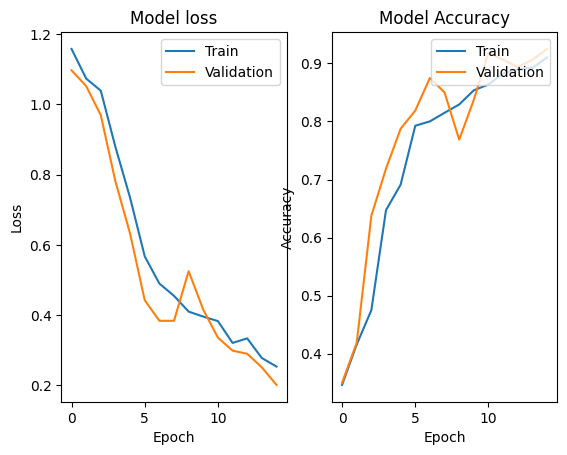

In [21]:
plt.subplot(1, 2, 1)
plt.plot(historyModel.history['loss'])
plt.plot(historyModel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(historyModel.history['accuracy'])
plt.plot(historyModel.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 164ms/step
Paper


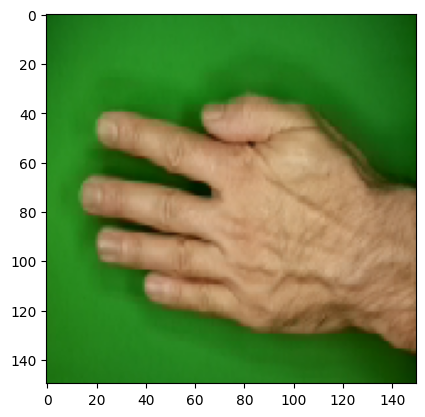

In [22]:
uploaded = os.path.join(paper_dir,'0Og76sl5CJhbxWWx.png')
img = tf.keras.utils.load_img(uploaded, target_size = (150, 150))
 
imgplot = plt.imshow(img)
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)  
if classes[0][0] == 1:
  print('Paper')
elif classes[0][1] == 1:
  print('Rock')
else:
  print('Scissors')

## Evaluation

In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_data, steps=val_data.n)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

 14/437 [..............................] - ETA: 3:07 - loss: 0.2253 - accuracy: 0.9199

437/437 [==============================] - 7s 14ms/step - loss: 0.2253 - accuracy: 0.9199
Test Loss: 0.2253248393535614
Test Accuracy: 0.9199084639549255


## Heat Map


In [42]:
# source: https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

1/1 [==============================] - 0s 48ms/step


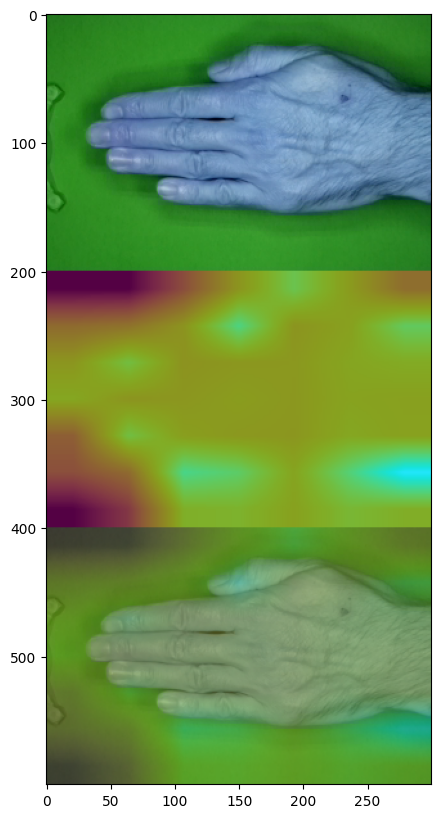

In [49]:
img_path = '/content/rps-cv-images/paper/0a3UtNzl5Ll3sq8K.png'

# Read the input image
img = cv2.imread(img_path)

# Resize the image to match the desired input shape
img = cv2.resize(img, (150, 150))

# Normalize the image by scaling pixel values between 0 and 1
img = img / 255.0

# Expand the dimensions of the image to match the expected input shape of the model
img = np.expand_dims(img, axis=0)

# Make predictions using the model
predictions = model.predict(img)

# Get the predicted class index with the highest probability
i = np.argmax(predictions[0])

# Create the GradCAM object with the model and the predicted class index
cam = GradCAM(model, i)

# Compute the heat map
heatmap = cam.compute_heatmap(img)

# Get the original image
orig = cv2.imread(img_path)

# Resize the heat map to match the size of the original image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))

# Overlay the heat map on the original image with transparency
heatmap, output = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# Concatenate the original image, heat map, and overlaid output vertically
output = np.vstack([orig, heatmap, output])

# Create a figure and plot the resulting image
fig = plt.figure(figsize=(10, 10))
plt.imshow(output, cmap=plt.cm.binary)

## Rock, Paper, Scissor Game

In [47]:
def game(hand_1, hand_2):
  img1 = tf.keras.utils.load_img(hand_1, target_size = (150, 150))
  
  #imgplot1 = plt.imshow(img1)
  x1 = tf.keras.utils.img_to_array(img1)
  x1 = np.expand_dims(x1, axis=0)
  images1 = np.vstack([x1])

  classes1 = model.predict(images1, batch_size=10)  

  img2 = tf.keras.utils.load_img(hand_2, target_size = (150, 150))
  
  #imgplot2 = plt.imshow(img2)
  x2 = tf.keras.utils.img_to_array(img2)
  x2 = np.expand_dims(x2, axis=0)
  images2 = np.vstack([x2])

  classes2 = model.predict(images2, batch_size=10)  

  plt.subplot(1, 2, 1)  # Create a subplot for img1
  plt.imshow(img1)
  plt.title('Image 1')
  plt.xlabel(f'Class: {np.argmax(classes1)}')

  plt.subplot(1, 2, 2)  # Create a subplot for img2
  plt.imshow(img2)
  plt.title('Image 2')
  plt.xlabel(f'Class: {np.argmax(classes2)}')

  plt.tight_layout()  # Adjust spacing between subplots
  plt.show()

  if classes1[0][0] == 1:
    h1 = 'paper'
  elif classes1[0][1] == 1:
    h1 = 'rock'
  else:
    h1 = 'scissors'


  if classes2[0][0] == 1:
    h2 = 'paper'
  elif classes2[0][1] == 1:
    h2 = 'rock'
  else:
    h2 = 'scissors'


  print("h1: ", h1)
  print("h2: ", h2)


  if h1 == 'paper':
    if h2 == 'rock':
      print("hand 1 won")
    elif h2 == 'paper':
      print("draw")
    else:
      print("hand 2 won")

  if h1 == 'rock':
    if h2 == 'paper':
      print("hand 2 won")
    elif h2 == 'rock':
      print("draw")
    else:
      print("hand 1 won")

  if h1 == 'scissors':
    if h2 == 'rock':
      print("hand 2 won")
    elif h2 == 'scissors':
      print("draw")
    else:
      print("hand 1 won")

1/1 [==============================] - 0s 29ms/step


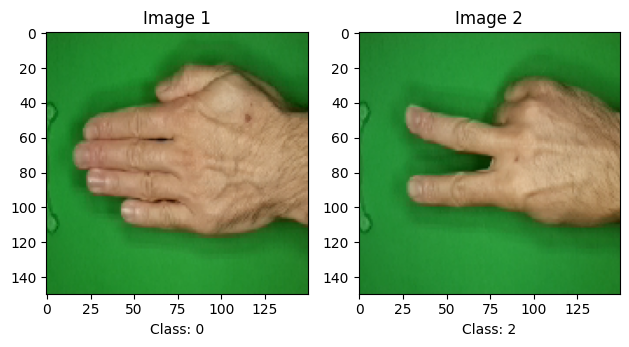

h1:  paper
h2:  scissors
hand 2 won


In [48]:
hand_1 = '/content/rps-cv-images/paper/0a3UtNzl5Ll3sq8K.png'
hand_2 = '/content/rps-cv-images/scissors/2M8LvUBGMOH1bsaz.png'

game(hand_1, hand_2)

1/1 [==============================] - 0s 117ms/step


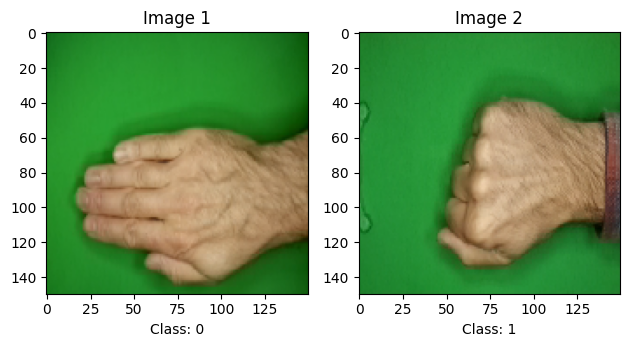

h1:  paper
h2:  rock
hand 1 won


In [53]:
hand_3 = '/content/rps-cv-images/paper/7YbjJFHGHPhJQFvE.png'
hand_4 = '/content/rps-cv-images/rock/Zyzp7nBCojgQeCZs.png'

game(hand_3, hand_4)